# APD Spending Trends

## Setting up our Notebook

Before we get to doing any actual work with data, we have to import the packaged libraries of code that we will use to conduct our analysis. Using already-existing libraries dramatically cuts down on the amount of code one has to write. 

The Python packages we are using are popular and well-documented; they will allows us to efficiently read, organize, and manipulate CSV data, as well as run statistical functions and visualize results.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Loading and preparing data

To adjust for changes in the real value of spending (as opposed to its nominal value), we use the Consumer Price Index. Here, we load data provided by the St. Louis Fed and average the monthly index to create an annual index.

In [2]:
monthly_cpi = pd.read_csv('CPIAUCSL.csv')
get_year = lambda row: int(row['DATE'][0:4])
monthly_cpi['year'] = monthly_cpi.apply(get_year, axis=1)
annual_cpi = monthly_cpi.groupby('year').mean()
annual_cpi.filter(range(2008, 2021), axis=0)

,CPIAUCSL
year,
2008,215.254250
2009,214.564667
2010,218.076167
2011,224.923000
2012,229.586083
2013,232.951750
2014,236.715000
2015,237.001750
2016,239.989167


We use the Austin City Demographer's population estimates for an annual Austin population figure. 

In [3]:
population = pd.read_csv('population_by_year.csv')
population.head(13)

,year,population
0,2008,750525
1,2009,774037
2,2010,790390
3,2011,812025
4,2012,832326
5,2013,855215
6,2014,878733
7,2015,900701
8,2016,926426
9,2017,949587


We use publicly-available adopted bugdet documents to arrive at the non-revenue general fund allocation to the Austin Police Department. The City demographer's population estimates are added to the budget data to arrive at a nominal per capita spending level.

In [4]:
gf_spending = pd.read_csv('police_gf_expenditures.csv')
gf_spending['year'] = gf_spending.apply(lambda row: int(row['year'][5:10]), axis=1)
gf_spending.insert(0, 'population', population.population)
gf_spending['per_capita'] = gf_spending.amount / gf_spending.population
gf_spending.head(13)

,population,year,amount,expenditure_type,source,per_capita
0,750525,2008,216730559,actual,2009-2010 Budget,288.771938
1,774037,2009,238329269,amended,2009-2010 Budget,307.904233
2,790390,2010,240737419,approved,2009-2010 Budget,304.580548
3,812025,2011,250607672,approved,2010-2011 Budget,308.620636
4,832326,2012,267248292,approved,2011-2012 Budget,321.086079
5,855215,2013,283874598,approved,2012-2013 Budget,331.933605
6,878733,2014,295356461,approved,2013-2014 Budget,336.116273
7,900701,2015,354943368,approved,2014-2015 Budget,394.074580
8,926426,2016,372070249,approved,2015-2016 Budget,401.618963
9,949587,2017,386573423,approved,2016-2017 Budget,407.096372


However, we want to adjust for inflation so that all the per capita figures represent present-day dollars. We calculate a factor for this adjustment using CPI data. This factor is added to the budget data.

In [5]:
current_year_cpi = annual_cpi[annual_cpi.index == 2020]
get_real_factor = lambda row: current_year_cpi['CPIAUCSL'] / row['CPIAUCSL']
annual_cpi['real_20_factor'] = annual_cpi.apply(get_real_factor, axis=1)
timeframe_cpi_factors = annual_cpi.tail(13).real_20_factor
gf_spending.insert(0, 'cpi_factor', timeframe_cpi_factors.values)
gf_spending['real_per_capita'] = gf_spending['per_capita'] * gf_spending['cpi_factor']
gf_spending.head(13)

,cpi_factor,population,year,amount,expenditure_type,source,per_capita,real_per_capita
0,1.198263,750525,2008,216730559,actual,2009-2010 Budget,288.771938,346.024792
1,1.202114,774037,2009,238329269,amended,2009-2010 Budget,307.904233,370.136076
2,1.182758,790390,2010,240737419,approved,2009-2010 Budget,304.580548,360.244967
3,1.146754,812025,2011,250607672,approved,2010-2011 Budget,308.620636,353.911812
4,1.123462,832326,2012,267248292,approved,2011-2012 Budget,321.086079,360.728022
5,1.107230,855215,2013,283874598,approved,2012-2013 Budget,331.933605,367.526965
6,1.089628,878733,2014,295356461,approved,2013-2014 Budget,336.116273,366.241643
7,1.088309,900701,2015,354943368,approved,2014-2015 Budget,394.074580,428.875099
8,1.074762,926426,2016,372070249,approved,2015-2016 Budget,401.618963,431.644822
9,1.052259,949587,2017,386573423,approved,2016-2017 Budget,407.096372,428.371023


## Analysis and Visualization

With this data, we can calculate the percentage decrease needed to be applied to present-day per capita spending to get it back inline with the starting point at the beginning of the series. We can also, therefore, calculate the total reduction amount to match present-day per capita with the starting point of the available data.

In [6]:
new_per_capita = gf_spending.loc[12].real_per_capita
old_per_capita = gf_spending.loc[0].real_per_capita
current_budget_amount = gf_spending.loc[12].amount
discount = (new_per_capita - old_per_capita) / new_per_capita
print(discount)
surplus = current_budget_amount * discount
print(surplus)

0.20358804505686434
88454067.5491747


We conclude by visualizing the real per capita change over time.

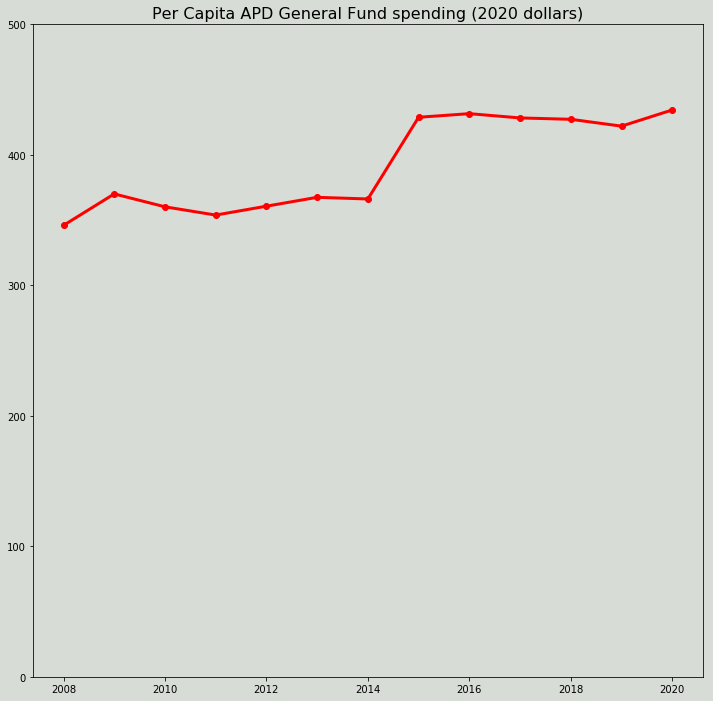

In [7]:
fig, axis = plt.subplots(figsize=(12, 12))
y_values = gf_spending['real_per_capita'].values
x_values = gf_spending['year'].values
axis.set_ylim(0,500)
axis.plot(x_values, y_values, color='red', marker="o", linewidth=3)
axis.set_title('Per Capita APD General Fund spending (2020 dollars)', fontsize=16)
face_color = "xkcd:light gray"
fig.patch.set_facecolor(face_color)
axis.set_facecolor(face_color)
plt.show()

*Informatx's Jupyter notebooks are available on [Github](https://github.com/jga/informatx-notebooks).*